# *__Make March less Mad 2020__*

## Import libraries

The following snippets of code come from the following notebook: 

https://www.kaggle.com/artgor/march-madness-2020-ncaam-eda-and-baseline

This code was used to simplify importing the data from Kaggle. 

In [2]:
# Libraries
import time
import pandas as pd
import random
import numpy as np
import sklearn
import xgboost as xgb
from time import time
from statistics import mean
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score , StratifiedKFold, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
import random
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import copy
import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix
import json
import ast
import time
from sklearn import linear_model
import statistics
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
import re
import os
import glob

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Classes to help import initial data set
class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)

In [0]:
# Classes to help import initial data set
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            pass
        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

        self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
                         or 'attempt' in col]

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [0]:
# Classes to help import initial data set
class ClassifierModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='auc',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """
        self.cols_to_drop = cols_to_drop

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1 if len(set(y.values)) == 2 else len(set(y.values))
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)
            # y = X['accuracy_group']

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict_proba(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(float)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
#             print(classification_report(y, self.oof.argmax(1)))
            print(classification_report(y, (self.oof > 0.5) * 1))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=25)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            g = sns.heatmap(confusion_matrix(y, (self.oof > 0.5) * 1), annot=True, cmap=plt.cm.Blues,fmt="d")
            g.set(ylim=(-0.5, 4), xlim=(-0.5, 4), title='Confusion matrix')

            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.xticks(range(self.n_target), range(self.n_target))
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]
            self.cols_to_drop = cols_to_drop
            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)
            if self.cols_to_drop:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict_proba(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        full_evals_results[self.eval_metric] = np.abs(full_evals_results[self.eval_metric])
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

## Import Data from Kaggle

In [8]:
# Run this cell and select the kaggle.json file downloaded from the Kaggle account settings page
# The kaggle account in question must have access to the Kaggle 2020 NCAA Tournament contest

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"robbiemoore","key":"eb58011570ab788e49cbda0546e027c5"}'}

In [9]:
# Set up connection with Kaggle

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!mkdir NCAA_data
%cd NCAA_data


/content/NCAA_data


In [11]:
# Download data from Kaggle

!kaggle competitions download -c google-cloud-ncaa-march-madness-2020-division-1-mens-tournament

 43% 9.00M/20.8M [00:00<00:00, 15.0MB/s]
100% 20.8M/20.8M [00:00<00:00, 30.5MB/s]
 43% 9.00M/20.8M [00:00<00:00, 15.8MB/s]
100% 20.8M/20.8M [00:00<00:00, 32.8MB/s]
 39% 9.00M/23.2M [00:00<00:01, 14.7MB/s]
100% 23.2M/23.2M [00:00<00:00, 34.0MB/s]
 85% 17.0M/20.1M [00:01<00:00, 5.03MB/s]
100% 20.1M/20.1M [00:01<00:00, 13.0MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 53.9MB/s]
 44% 9.00M/20.4M [00:00<00:00, 12.7MB/s]
100% 20.4M/20.4M [00:00<00:00, 28.0MB/s]
 87% 22.0M/25.2M [00:00<00:00, 12.5MB/s]
100% 25.2M/25.2M [00:01<00:00, 26.1MB/s]
  0% 0.00/54.0k [00:00<?, ?B/s]
100% 54.0k/54.0k [00:00<00:00, 55.6MB/s]
  0% 0.00/33.6k [00:00<?, ?B/s]
100% 33.6k/33.6k [00:00<00:00, 33.4MB/s]
  0% 0.00/21.6k [00:00<?, ?B/s]
100% 21.6k/21.6k [00:00<00:00, 22.1MB/s]
  0% 0.00/14.4k [00:00<?, ?B/s]
100% 14.4k/14.4k [00:00<00:00, 15.0MB/s]
  0% 0.00/2.78M [00:00<?, ?B/s]
100% 2.78M/2.78M [00:00<00:00, 91.9MB/s]
  0% 0.00/133k [00:00<?, ?B/s]
100% 133k/133k [00:00<00:00, 120MB/s]
  0%

## Loading the data

Let's load all useful data into a single dictionary!

In [12]:
# Create DataFrame dictionary with all data

data_dict = {}
for i in glob.glob('/content/NCAA_data/*'):
    name = i.split('/')[-1].split('.')[0]
    if name != 'MTeamSpellings':
        data_dict[name] = pd.read_csv(i)
    else:
        data_dict[name] = pd.read_csv(i, encoding='cp1252')

data_dict.keys()

dict_keys(['MRegularSeasonDetailedResults', 'MEvents2019', 'MEvents2020', 'MEvents2016', 'MMasseyOrdinals', 'MNCAATourneySeeds', 'MEvents2015', 'MTeamCoaches', 'MSeasons', 'MSecondaryTourneyCompactResults', 'MPlayers', 'MNCAATourneySlots', 'MRegularSeasonCompactResults', 'MNCAATourneyCompactResults', 'MTeamSpellings', 'MNCAATourneySeedRoundSlots', 'MEvents2017', 'MEvents2018', 'MConferenceTourneyGames', 'MGameCities', 'Conferences', 'Cities', 'MSampleSubmissionStage1_2020', 'MNCAATourneyDetailedResults', 'MTeamConferences', 'MSecondaryTourneyTeams', 'MTeams'])

# **Start of our code**

**Function Declarations**

In [0]:
# Used to swap from Winning/Losing Teams into Home/Away Teams
def home_conditions(s):
    if s['WLoc'] == 'H' or s['WLoc'] == 'N':
        return s['WTeamID'], s['WScore'],s['WFGM'], s['WFGA'], s['WFGM3'], s['WFGA3'], s['WFTM'], s['WFTA'], s['WOR'], s['WDR'], s['WAst'], s['WTO'], s['WStl'], s['WBlk'], s['WPF']
    else:
        return s['LTeamID'], s['LScore'], s['LFGM'], s['LFGA'], s['LFGM3'], s['LFGA3'], s['LFTM'], s['LFTA'], s['LOR'], s['LDR'], s['LAst'], s['LTO'], s['LStl'], s['LBlk'], s['LPF']

# Used to swap from Winning/Losing Teams into Home/Away Teams
def away_conditions(s):
    if s['WLoc'] == 'H' or s['WLoc'] == 'N':
        return s['LTeamID'], s['LScore'], s['LFGM'], s['LFGA'], s['LFGM3'], s['LFGA3'], s['LFTM'], s['LFTA'], s['LOR'], s['LDR'], s['LAst'], s['LTO'], s['LStl'], s['LBlk'], s['LPF']
    else:
        return s['WTeamID'], s['WScore'], s['WFGM'], s['WFGA'], s['WFGM3'], s['WFGA3'], s['WFTM'], s['WFTA'], s['WOR'], s['WDR'], s['WAst'], s['WTO'], s['WStl'], s['WBlk'], s['WPF'] 

# Calculate Effective Field Goal Percentage
def efg(s):
    return ((s['HFGM']+0.5*s['HFGM3'])/s['HFGA']), ((s['AFGM']+0.5*s['AFGM3'])/s['AFGA'])

# Calculate Turnover Percentage
def turnover(s):
    return (s['HTO']/(s['HFGA'] + 0.44*s['HFTA']+s['HTO'])), (s['ATO']/(s['AFGA'] + 0.44*s['AFTA']+s['ATO']))

# Calculate Offensive Rebounding Percentage
def rebound(s):
    hOR = s['HOR']/(s['HOR']+s['ADR'])
    hDR = s['HDR']/(s['HDR']+s['AOR'])
    aOR = s['AOR']/(s["AOR"]+s['HDR'])
    aDR = s['ADR']/(s["ADR"]+s['HOR'])
    return hOR, hDR, aOR, aDR

# Calculate Free Throw Percentage
def ft(s):
    return s['HFTA']/s['HFGA'], s['AFTA']/s['AFGA']

# Takes dataframe of last N games for Team X and swaps from Home/Away into Team X vs Opponent
def clean_last_n(df, teamID):
    cols = ['TeamID', 'OpponentID','Season', 'DayNum', 'Location', 'eFG', 'TOP', 'ORP','DRP', 'FTP', 'O_eFG', 'O_TOP', 'O_ORP', 'O_DRP', 'O_FTP', 'Winner']
    df_out = pd.DataFrame(columns = cols)
    for index, row in df.iterrows():
        new_row = {}
        new_row['TeamID'] = teamID
        new_row['Season'] = row['Season']
        new_row['DayNum'] = row['DayNum']
        new_row['Winner'] = row['Winner']
        if row['HomeTeamID'] == teamID:
            new_row['OpponentID'] = row['AwayTeamID']
            new_row['Location'] = 'H'
            new_row['eFG'] = row['H_eFG']
            new_row['TOP'] = row['H_TOP']
            new_row['ORP'] = row['H_ORP']
            new_row['DRP'] = row['H_DRP']
            new_row['FTP'] = row['H_FTP']
            new_row['O_eFG'] = row['A_eFG']
            new_row['O_TOP'] = row['A_TOP']
            new_row['O_ORP'] = row['A_ORP']
            new_row['O_DRP'] = row['A_DRP']
            new_row['O_FTP'] = row['A_FTP']
        else:
            new_row['OpponentID'] = row['HomeTeamID']
            new_row['Location'] = 'A'
            new_row['eFG'] = row['A_eFG']
            new_row['TOP'] = row['A_TOP']
            new_row['ORP'] = row['A_ORP']
            new_row['DRP'] = row['A_DRP']
            new_row['FTP'] = row['A_FTP']
            new_row['O_eFG'] = row['H_eFG']
            new_row['O_TOP'] = row['H_TOP']
            new_row['O_ORP'] = row['H_ORP']
            new_row['O_DRP'] = row['H_DRP']
            new_row['O_FTP'] = row['H_FTP']
        df_out = df_out.append(new_row, ignore_index=True)
    return df_out

# Takes a team, season and day, finds the last n games, cleans and returns df of last n
def get_n_recent_games(df, teamID, season, day, num_games = 5):
    query = '(HomeTeamID=={} or AwayTeamID=={}) and Season=={}'.format(teamID, teamID, season)
    team_games = df.query(query)
    team_games.reset_index(inplace=True)
    game_index = team_games.loc[team_games['DayNum'] == day].index[0]
    if game_index >= num_games:
        cleaned = clean_last_n(team_games.iloc[game_index-num_games:game_index], teamID)
        return cleaned

# Takes a team, season and number of games and returns a dataframe of that teams results in the last n games
def bracket_n_recent_games(df, season, teamID, gameNum):
    query = '(HomeTeamID=={} or AwayTeamID=={}) and Season=={}'.format(teamID, teamID, season)
    team_games = df.query(query)
    team_games.reset_index(inplace=True)
    return clean_last_n(team_games.tail(gameNum), teamID)


def get_n_raw_recent_games(df, teamID, season, day, num_games = 5):
    query = '(HomeTeamID=={} or AwayTeamID=={}) and Season=={}'.format(teamID, teamID, season)
    team_games = df.query(query)
    team_games.reset_index(inplace=True)
    game_index = team_games.loc[team_games['DayNum'] == day].index[0]
    if game_index >= num_games:
        cleaned = clean_last_n(team_games.iloc[game_index-num_games:game_index], teamID)
        return cleaned
    else:
        return None



# For Page Rank
def sortSecond(val):
    return val[1]

# Given a set of games (Organized into Home/Away) returns a pagerank list of all teams
def page_rank_df(rs_df, year = None, alpha = 0.85, x = 0.5, y = 1):
  if year:
      rs_df = rs_df.loc[rs_df['Season'] == year]
  pagerank_df = np.zeros((1467 - 1100,1467 - 1100))
  for ind in rs_df.index:
    if rs_df['Winner'][ind] == 'H':
      pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 5*x
    else:
      pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 5*x
    if rs_df['H_eFG'][ind] > rs_df['A_eFG'][ind]:
      pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 4*y
    elif rs_df['H_eFG'][ind] < rs_df['A_eFG'][ind]:
      pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 4*y
    if rs_df['H_TOP'][ind] < rs_df['A_TOP'][ind]:
      pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 2.5*y
    elif rs_df['H_TOP'][ind] > rs_df['A_TOP'][ind]:
      pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 2.5*y
    if rs_df['H_ORP'][ind] > rs_df['A_ORP'][ind] :
      pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 2*y
    elif rs_df['H_ORP'][ind] < rs_df['A_ORP'][ind]:
      pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 2*y
    if rs_df['H_FTP'][ind] > rs_df['A_FTP'][ind]:
      pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 1.5*y
    elif rs_df['H_FTP'][ind] < rs_df['A_FTP'][ind]:
      pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 1.5*y

  G = nx.DiGraph(pagerank_df)
  pr = nx.pagerank(G, alpha = alpha)
  ranking = []
  for i in pr :
      ranking.append((i + 1101, pr[i]))
  ranking.sort(key = sortSecond, reverse=True)
  return ranking

# Given a set of pagerankings, determine accuracy if higher pagerank team 
# always assumed to win
def pagerank_tournament_results(page_ranks, year):
    correct = 0
    incorrect = 0
    df = data_dict['MNCAATourneyCompactResults'].copy()
    df = df.loc[df['Season'] == year]
    for index, row in df.iterrows():
        win_index = [i for i, tupl in enumerate(page_ranks) if tupl[0] == row['WTeamID']]
        lose_index = [i for i, tupl in enumerate(page_ranks) if tupl[0] == row['LTeamID']]
        if win_index < lose_index:
            correct = correct + 1
        else:
            incorrect = incorrect + 1
    return correct/(correct+incorrect)

# Given a March Madness Bracket, return the accuracy if the higher seed always wins
# Coin flip if equal seeds (does not happen often, only in final 3 games, if at all) 
def seeding_tournament_results(df):
    correct = 0
    incorrect = 0
    for index, row in df.iterrows():
        if row['WTeamSeed'] < row['LTeamSeed']:
            correct += 1
        elif row['WTeamSeed'] > row['LTeamSeed']:
            incorrect += 1
        else:
            flip = random.uniform(0, 1)
            if flip == 1:
                correct += 1 
            else:
                incorrect += 1
    return correct/(correct+incorrect)

def winner_to_binary(df):
    df.loc[df['Winner'] == 'H', ['Winner']] = 1
    df.loc[df['Winner'] == 'A', ['Winner']] = 0
    return df

cols = ['Test Info','RF_Accuracy', 'RF_Precision', 'RF_AUC', 'RF_Recall', 'RF_F_Score','XG_Accuracy', \
        'XG_Precision', 'XG_AUC', 'XG_Recall', 'XG_F_Score']
results_df = pd.DataFrame(columns=cols)   

# Appends prediction results to results df
def append_results(results_df, test_info, RF_res, XG_res):
    cols = ['Test Info', 'RF_Accuracy', 'RF_Precision', 'RF_AUC', 'RF_Recall', 'RF_F_Score',
            'XG_Accuracy','XG_Precision', 'XG_AUC', 'XG_Recall', 'XG_F_Score']
    new_row = dict.fromkeys(cols)
    new_row['Test Info'] = test_info
    new_row['RF_Accuracy'] = mean(RF_res['Accuracy'])
    new_row['RF_Precision'] = mean(RF_res['Precision'])
    new_row['RF_Recall'] = mean(RF_res['Recall'])
    new_row['RF_AUC'] = mean(RF_res['AUC'])
    new_row['RF_F_Score'] = mean(RF_res['F-score'])
    
    new_row['XG_Accuracy'] = mean(XG_res['Accuracy'])
    new_row['XG_Precision'] = mean(XG_res['Precision'])
    new_row['XG_Recall'] = mean(XG_res['Recall'])
    new_row['XG_AUC'] = mean(XG_res['AUC'])
    new_row['XG_F_Score'] = mean(XG_res['F-score'])
    results_df = results_df.append(new_row, ignore_index=True)
    return results_df

# Used to Display overall prediction results
def display_results(RF_res, XG_res):
    cols = ['Test Info', 'RF_Accuracy', 'RF_Precision', 'RF_AUC', 'RF_Recall', 'RF_F_Score',
            'XG_Accuracy','XG_Precision', 'XG_AUC', 'XG_Recall', 'XG_F_Score']
    new_row = dict.fromkeys(cols)
    new_row['RF_Accuracy'] = mean(RF_res['Accuracy'])
    new_row['RF_Precision'] = mean(RF_res['Precision'])
    new_row['RF_Recall'] = mean(RF_res['Recall'])
    new_row['RF_AUC'] = mean(RF_res['AUC'])
    new_row['RF_F_Score'] = mean(RF_res['F-score'])
    
    new_row['XG_Accuracy'] = mean(XG_res['Accuracy'])
    new_row['XG_Precision'] = mean(XG_res['Precision'])
    new_row['XG_Recall'] = mean(XG_res['Recall'])
    new_row['XG_AUC'] = mean(XG_res['AUC'])
    new_row['XG_F_Score'] = mean(XG_res['F-score'])
    print(new_row)

# Report top 3 candidates from hyperparameter tuning
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def winner_to_binary(df):
    df.loc[df['Winner'] == 'H', ['Winner']] = 1
    df.loc[df['Winner'] == 'A', ['Winner']] = 0
    return df

def get_bracket_game_info(temp_row, home_info, away_info):
    temp_row['H_eFG'] = home_info['eFG']
    temp_row['H_TOP'] = home_info['TOP']
    temp_row['H_ORP'] = home_info['ORP']
    temp_row['H_DRP'] = home_info['DRP']
    temp_row['H_FTP'] = home_info['FTP']
    temp_row['H_PageRank'] = home_info['PR']
    temp_row['A_eFG'] = away_info['eFG']
    temp_row['A_TOP'] = away_info['TOP']
    temp_row['A_ORP'] = away_info['ORP']
    temp_row['A_DRP'] = away_info['DRP']
    temp_row['A_FTP'] = away_info['FTP']
    temp_row['A_PageRank'] = away_info['PR']
    return temp_row


**Import regular season data, convert DataFrame from Winner/Loser stats to Home/Away stats**

In [14]:
rs_df = data_dict['MRegularSeasonDetailedResults'].copy()
rs_df = rs_df[rs_df['WLoc'] != "N"]
rs_df = rs_df.drop(['NumOT'], axis=1)
#rs_df = rs_df.loc[rs_df['Season'] >= 2010]

conf = data_dict['MTeams'].copy()
teams = conf.loc[conf['LastD1Season'] != 2020]
not_d1 = teams['TeamID'].tolist()

for team in not_d1:
    rs_df = rs_df[rs_df['WTeamID'] != team]
    rs_df = rs_df[rs_df['LTeamID'] != team]

columns = ['']


rs_df['HomeTeamID'], rs_df['HScore'], rs_df['HFGM'], rs_df['HFGA'], rs_df['HFGM3'], rs_df['HFGA3'], rs_df['HFTM'], rs_df['HFTA'], rs_df['HOR'], rs_df['HDR'], rs_df['HAST'], rs_df['HTO'], rs_df['HStl'], rs_df['HBlk'], rs_df['HPF'] = zip(*rs_df.apply(home_conditions, axis=1))
rs_df['AwayTeamID'], rs_df['AScore'], rs_df['AFGM'], rs_df['AFGA'], rs_df['AFGM3'], rs_df['AFGA3'], rs_df['AFTM'], rs_df['AFTA'], rs_df['AOR'], rs_df['ADR'], rs_df['AAST'], rs_df['ATO'], rs_df['AStl'], rs_df['ABlk'], rs_df['APF'] = zip(*rs_df.apply(away_conditions, axis=1))
rs_df['H_eFG'], rs_df['A_eFG'] = zip(*rs_df.apply(efg, axis=1))
rs_df['H_ORP'], rs_df['H_DRP'], rs_df['A_ORP'], rs_df['A_DRP'] = zip(*rs_df.apply(rebound, axis=1))
rs_df['H_TOP'], rs_df['A_TOP'] = zip(*rs_df.apply(turnover, axis=1))
rs_df['H_FTP'], rs_df['A_FTP'] = zip(*rs_df.apply(ft, axis=1))


rs_df = rs_df.drop(['WTeamID', 'WScore', 'LTeamID', 'LScore', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR','WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3','LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'], axis=1)
rs_df = rs_df.loc[rs_df['WLoc'] != 'N']
rs_df = rs_df.rename(columns={"WLoc": "Winner"})
rs_df


,Season,DayNum,Winner,HomeTeamID,HScore,HFGM,HFGA,HFGM3,HFGA3,HFTM,HFTA,HOR,HDR,HAST,HTO,HStl,HBlk,HPF,AwayTeamID,AScore,AFGM,AFGA,AFGM3,AFGA3,AFTM,AFTA,AOR,ADR,AAST,ATO,AStl,ABlk,APF,H_eFG,A_eFG,H_ORP,H_DRP,A_ORP,A_DRP,H_TOP,A_TOP,H_FTP,A_FTP
5,2003,11,H,1458,81,26,57,6,12,23,27,12,24,12,9,9,3,18,1186,55,20,46,3,11,12,17,6,22,8,19,4,3,25,0.508772,0.467391,0.352941,0.800000,0.200000,0.647059,0.115562,0.262141,0.473684,0.369565
6,2003,12,H,1161,80,23,55,2,8,32,39,13,18,14,17,11,1,25,1236,62,19,41,4,15,20,28,9,21,11,30,10,4,28,0.436364,0.512195,0.382353,0.666667,0.333333,0.617647,0.190668,0.360058,0.709091,0.682927
9,2003,12,H,1458,84,32,67,5,17,15,19,14,22,11,6,12,0,13,1296,56,23,52,3,14,7,12,9,23,10,18,1,3,18,0.514925,0.471154,0.378378,0.709677,0.290323,0.621622,0.073746,0.239107,0.283582,0.230769
10,2003,13,H,1166,106,41,69,15,25,9,13,15,29,21,11,10,6,16,1426,50,17,52,4,11,12,17,8,15,8,17,7,3,15,0.702899,0.365385,0.500000,0.783784,0.216216,0.500000,0.128325,0.222280,0.188406,0.326923
13,2003,13,H,1323,76,25,56,10,23,16,23,8,35,18,13,14,19,13,1125,48,18,64,8,24,4,8,14,26,12,17,10,0,17,0.535714,0.343750,0.235294,0.714286,0.285714,0.764706,0.164307,0.201136,0.410714,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87445,2019,130,H,1272,79,26,57,8,27,19,29,14,27,16,13,9,2,19,1416,55,19,53,6,20,11,19,8,22,7,16,6,6,21,0.526316,0.415094,0.388889,0.771429,0.228571,0.611111,0.157081,0.206825,0.508772,0.358491
87479,2019,131,A,1272,58,16,68,4,23,22,26,21,26,4,9,5,5,21,1222,61,21,57,5,19,14,27,16,32,8,14,4,9,22,0.264706,0.412281,0.396226,0.619048,0.380952,0.603774,0.101764,0.168919,0.382353,0.473684
87495,2019,131,H,1436,66,21,51,7,22,17,23,11,27,7,11,5,5,16,1420,49,15,44,8,26,11,14,4,23,9,13,6,4,19,0.480392,0.431818,0.323529,0.870968,0.129032,0.676471,0.152524,0.205826,0.450980,0.318182
87497,2019,131,H,1463,83,31,61,5,16,16,16,6,26,16,8,8,2,18,1343,77,28,62,6,24,15,20,9,24,9,10,4,1,17,0.549180,0.500000,0.200000,0.742857,0.257143,0.800000,0.105208,0.123762,0.262295,0.322581


In [15]:
bracket_df = data_dict['MNCAATourneyDetailedResults']
bracket_df = bracket_df.drop(['NumOT'], axis=1)
seeds_info = data_dict['MNCAATourneySeeds']

years = list(bracket_df['Season'].unique())
column_names = ["Season", 'Seed', 'TeamID', 'eFG', 'TOP','ORP','DRP', 'FTP']
bracket_info_df = pd.DataFrame(columns=column_names)
for year in years:
    seeds_list = seeds_info.loc[seeds_info['Season'] == year]
    teams_list = list(seeds_list['TeamID'].unique())
    for team in teams_list:
        new_row = {}
        new_row['Season'] = year 
        new_row['TeamID'] = team
        new_row['Seed'] = seeds_list.loc[seeds_list['TeamID'] == team]['Seed'].values[0]
        team_last_n = bracket_n_recent_games(rs_df, year, team, 9)
        new_row['eFG'] = team_last_n['eFG'].mean()
        new_row['TOP'] = team_last_n['TOP'].mean()
        new_row['ORP'] = team_last_n['ORP'].mean()
        new_row['DRP'] = team_last_n['DRP'].mean()
        new_row['FTP'] = team_last_n['FTP'].mean()
        bracket_info_df = bracket_info_df.append(new_row, ignore_index=True)
bracket_info_df

,Season,Seed,TeamID,eFG,TOP,ORP,DRP,FTP
0,2003,W01,1328,0.517941,0.159316,0.301958,0.694789,0.314884
1,2003,W02,1448,0.509002,0.188668,0.380475,0.653881,0.486225
2,2003,W03,1393,0.510304,0.147629,0.347397,0.663143,0.320234
3,2003,W04,1257,0.491600,0.141670,0.355395,0.635465,0.472745
4,2003,W05,1280,0.515097,0.189496,0.368306,0.655163,0.317956
...,...,...,...,...,...,...,...,...
1127,2019,Z12,1332,0.531113,0.156908,0.287632,0.751316,0.250592
1128,2019,Z13,1414,0.548894,0.138601,0.359252,0.748985,0.254258
1129,2019,Z14,1330,0.476071,0.156544,0.337115,0.739211,0.353222
1130,2019,Z15,1159,0.625472,0.174592,0.275727,0.745044,0.333196


**Generate Local Scope DataFrame**

The following snippet will take the Home/Away DataFrame and convert each game into a prediction ready row. Each row contains the game information and an average of each teams big four factors over the last n games. 

In [0]:
# Averaged last n games
column_names = ["Season", "DayNum", "HomeTeamID", "H_eFG", "H_TOP","H_ORP","H_DRP", "H_FTP", "AwayTeamID", "A_eFG", "A_TOP", "A_ORP", "A_DRP", "A_FTP", "Winner"]
cleaned_df = pd.DataFrame(columns = column_names)
num_rows = rs_df.shape[0]
for index, row in rs_df.iterrows():
    if index % 1000 == 0:
        print("Completed {}".format(index/num_rows))
    new_row = {}
    new_row['DayNum'] = row['DayNum']
    new_row['Season'] = row['Season']
    new_row['HomeTeamID'] = row['HomeTeamID']
    new_row['AwayTeamID'] = row['AwayTeamID']
    new_row['Winner'] = row['Winner']
    home = get_n_recent_games(rs_df, new_row['HomeTeamID'], row['Season'], row['DayNum'], 3)
    away = get_n_recent_games(rs_df, new_row['AwayTeamID'], row['Season'], row['DayNum'], 3)
    if type(home) != type(cleaned_df) or type(away) != type(cleaned_df):
        continue
    else:
        new_row['H_eFG'] = home['eFG'].mean()
        new_row['A_eFG'] = away['eFG'].mean()
        new_row['H_TOP'] = home['TOP'].mean()
        new_row['A_TOP'] = away['TOP'].mean()
        new_row['H_ORP'] = home['ORP'].mean()
        new_row['A_ORP'] = away['ORP'].mean()
        new_row['H_DRP'] = home['DRP'].mean()
        new_row['A_DRP'] = away['DRP'].mean()
        new_row['H_FTP'] = home['FTP'].mean()
        new_row['A_FTP'] = away['FTP'].mean()
    cleaned_df = cleaned_df.append(new_row, ignore_index=True)


In [0]:
# Non averaged last 3

column_names = ["Season", "DayNum", "HomeTeamID", "H_1_eFG", "H_1_TOP","H_1_ORP", \
                "H_1_DRP", "H_1_FTP", "H_2_eFG", "H_2_TOP","H_2_ORP","H_2_DRP", \
                "H_2_FTP", "H_3_eFG", "H_3_TOP","H_3_ORP","H_3_DRP", "H_3_FTP", \
                "AwayTeamID", "A_1_eFG", "A_1_TOP","A_1_ORP","A_1_DRP", "A_1_FTP", \
                 "A_2_eFG", "A_2_TOP","A_2_ORP","A_2_DRP", "A_2_FTP", "A_3_eFG", 
                "A_3_TOP","A_3_ORP","A_3_DRP", "A_3_FTP", "Winner"]
cleaned_df = pd.DataFrame(columns = column_names)
num_rows = rs_df.shape[0]
for index, row in rs_df.iterrows():
    if index % 1000 == 0:
        print("Completed {}".format(index/num_rows))
    new_row = {}
    new_row['DayNum'] = row['DayNum']
    new_row['Season'] = row['Season']
    new_row['HomeTeamID'] = row['HomeTeamID']
    new_row['AwayTeamID'] = row['AwayTeamID']
    new_row['Winner'] = row['Winner']
    home = get_n_raw_recent_games(rs_df, new_row['HomeTeamID'], row['Season'], row['DayNum'], 3)
    away = get_n_raw_recent_games(rs_df, new_row['AwayTeamID'], row['Season'], row['DayNum'], 3)
    if type(home) != type(cleaned_df) or type(away) != type(cleaned_df):
        continue
    else:
        new_row['H_1_eFG'] = home.loc[0,['eFG']][0]
        new_row['A_1_eFG'] = away.loc[0,['eFG']][0]
        new_row['H_1_TOP'] = home.loc[0,['TOP']][0]
        new_row['A_1_TOP'] = away.loc[0,['TOP']][0]
        new_row['H_1_ORP'] = home.loc[0,['ORP']][0]
        new_row['A_1_ORP'] = away.loc[0,['ORP']][0]
        new_row['H_1_DRP'] = home.loc[0,['DRP']][0]
        new_row['A_1_DRP'] = away.loc[0,['DRP']][0]
        new_row['H_1_FTP'] = home.loc[0,['FTP']][0]
        new_row['A_1_FTP'] = away.loc[0,['FTP']][0]
        new_row['H_2_eFG'] = home.loc[1,['eFG']][0]
        new_row['A_2_eFG'] = away.loc[1,['eFG']][0]
        new_row['H_2_TOP'] = home.loc[1,['TOP']][0]
        new_row['A_2_TOP'] = away.loc[1,['TOP']][0]
        new_row['H_2_ORP'] = home.loc[1,['ORP']][0]
        new_row['A_2_ORP'] = away.loc[1,['ORP']][0]
        new_row['H_2_DRP'] = home.loc[1,['DRP']][0]
        new_row['A_2_DRP'] = away.loc[1,['DRP']][0]
        new_row['H_2_FTP'] = home.loc[1,['FTP']][0]
        new_row['A_2_FTP'] = away.loc[1,['FTP']][0]
        new_row['H_3_eFG'] = home.loc[2,['eFG']][0]
        new_row['A_3_eFG'] = away.loc[2,['eFG']][0]
        new_row['H_3_TOP'] = home.loc[2,['TOP']][0]
        new_row['A_3_TOP'] = away.loc[2,['TOP']][0]
        new_row['H_3_ORP'] = home.loc[2,['ORP']][0]
        new_row['A_3_ORP'] = away.loc[2,['ORP']][0]
        new_row['H_3_DRP'] = home.loc[2,['DRP']][0]
        new_row['A_3_DRP'] = away.loc[2,['DRP']][0]
        new_row['H_3_FTP'] = home.loc[2,['FTP']][0]
        new_row['A_3_FTP'] = away.loc[2,['FTP']][0]
    cleaned_df = cleaned_df.append(new_row, ignore_index=True)

**Create Rankings using Pagerank for each season**

In [0]:
# Create Yearly Page Ranks Dictionary

years = rs_df['Season'].unique()
yearly_rankings = {}
for year in years:
    year_df = rs_df.loc[rs_df['Season'] == year]
    rankings = page_rank_df(year_df)
    yearly_rankings[year] = rankings

**Append Pagerankings as an Attribute to Local Scope DataFrame**

In [0]:
# Append Pageranking to dataframe, actual ranking

cleaned_df['H_PageRank'] = 0
cleaned_df['A_PageRank'] = 0
num_rows = rs_df.shape[0]
for index, row in cleaned_df.iterrows():
    if index%1000==0:
        print("Completed {}".format(index/num_rows))
    if row['Season']-1 > 2002:
        year_rankings = yearly_rankings[row['Season']-1]
        home_index = [i for i, tupl in enumerate(year_rankings) if tupl[0] == row['HomeTeamID']]
        away_index = [i for i, tupl in enumerate(year_rankings) if tupl[0] == row['AwayTeamID']]
        cleaned_df['H_PageRank'].iloc[index] = home_index[0]
        cleaned_df['A_PageRank'].iloc[index] = away_index[0]


In [0]:
# Append Pageranking to dataframe, probability value

cleaned_df['H_PageRank'] = 0
cleaned_df['A_PageRank'] = 0
num_rows = rs_df.shape[0]
for index, row in cleaned_df.iterrows():
    if index%1000==0:
        print("Completed {}".format(index/num_rows))
    if row['Season']-1 > 2002:
        year_rankings = yearly_rankings[row['Season']-1]
        home_index = [i for i, tupl in enumerate(year_rankings) if tupl[0] == row['HomeTeamID']]
        away_index = [i for i, tupl in enumerate(year_rankings) if tupl[0] == row['AwayTeamID']]
        cleaned_df['H_PageRank'].iloc[index] = year_rankings[home_index[0]][1]
        cleaned_df['A_PageRank'].iloc[index] = year_rankings[away_index[0]][1]

In [30]:
# Append Pageranking to bracket df, probability value

bracket_info_df['PR'] = 0
num_rows = bracket_df.shape[0]
for index, row in bracket_info_df.iterrows():
    if index%1000==0:
        print("Completed {}".format(index/num_rows))
    if row['Season'] > 2002:
        year_rankings = yearly_rankings[row['Season']]
        home_index = [i for i, tupl in enumerate(year_rankings) if tupl[0] == row['TeamID']]
        bracket_info_df['PR'].iloc[index] = year_rankings[home_index[0]][1]

Completed 0.0
Completed 0.8968609865470852


In [17]:
bracket_info_df

,Season,Seed,TeamID,eFG,TOP,ORP,DRP,FTP
0,2003,W01,1328,0.517941,0.159316,0.301958,0.694789,0.314884
1,2003,W02,1448,0.509002,0.188668,0.380475,0.653881,0.486225
2,2003,W03,1393,0.510304,0.147629,0.347397,0.663143,0.320234
3,2003,W04,1257,0.491600,0.141670,0.355395,0.635465,0.472745
4,2003,W05,1280,0.515097,0.189496,0.368306,0.655163,0.317956
...,...,...,...,...,...,...,...,...
1127,2019,Z12,1332,0.531113,0.156908,0.287632,0.751316,0.250592
1128,2019,Z13,1414,0.548894,0.138601,0.359252,0.748985,0.254258
1129,2019,Z14,1330,0.476071,0.156544,0.337115,0.739211,0.353222
1130,2019,Z15,1159,0.625472,0.174592,0.275727,0.745044,0.333196


**Fetch Tournament Seed Data**

In [0]:
# Generate results dictionary
seeds_info = data_dict['MNCAATourneySeeds']
bracket_df = bracket_df.loc[bracket_df['Season']>=2003]
years = list(bracket_df['Season'].unique())
output_dict = {}
for year in years:
    temp = bracket_df.loc[bracket_df['Season'] == year]
    temp.reset_index(inplace=True)
    temp = temp.sort_values(by=['DayNum'], ascending=False)
    yearly_dict = {}
    yearly_dict['RoundOf64'] = []
    yearly_dict['RoundOf32'] = []
    yearly_dict['SweetSixteen'] = []
    yearly_dict['EliteEight'] = []
    yearly_dict['FinalFour'] = []
    yearly_dict['Finals'] = []
    for index, game in temp.iterrows():
        key = "Game_{}".format(index)
        temp = {}
        temp['DayNum'] = game['DayNum']
        temp['WTeamID'] = game['WTeamID']
        temp['WTeamSeed'] = seeds_info.query('TeamID == {} and Season == {}'.format(game['WTeamID'], year))['Seed'].values[0]
        temp['LTeamID'] = game['LTeamID']
        temp['LTeamSeed'] = seeds_info.query('TeamID == {} and Season == {}'.format(game['LTeamID'], year))['Seed'].values[0]
        if year <= 2010:
            if index >= 63:
                yearly_dict['Finals'].append(temp)
            elif 61 <= index <= 62:
                yearly_dict['FinalFour'].append(temp)
            elif 57 <= index <= 60:
                yearly_dict['EliteEight'].append(temp)
            elif 49 <= index <= 56:
                yearly_dict['SweetSixteen'].append(temp)
            elif 33 <= index <= 48:
                yearly_dict['RoundOf32'].append(temp)
            elif  1 <= index <= 32:
                yearly_dict['RoundOf64'].append(temp)
        else:
            if index >= 66:
                yearly_dict['Finals'].append(temp)
            elif 64 <= index <= 65:
                yearly_dict['FinalFour'].append(temp)
            elif 60 <= index <= 63:
                yearly_dict['EliteEight'].append(temp)
            elif 52 <= index <= 59:
                yearly_dict['SweetSixteen'].append(temp)
            elif 36 <= index <= 51:
                yearly_dict['RoundOf32'].append(temp)
            elif  4 <= index <= 35:
                yearly_dict['RoundOf64'].append(temp)
    output_dict[year] = yearly_dict


In [0]:
# Create robbie lists for round of 64

rounds_of_64 = {}
for key, value in enumerate(output_dict):
    rounds_of_64[value] = []
    temp = output_dict[value]
    temp = temp['RoundOf64']
    temp_df = pd.DataFrame.from_dict(temp)
    temp_df['WTeamSeed'] = temp_df['WTeamSeed'].map(lambda x: x.rstrip('ab'))
    temp_df['LTeamSeed'] = temp_df['LTeamSeed'].map(lambda x: x.rstrip('ab'))
    quadrant = ['W','X','Y','Z']
    seeds = ['01','16','08','09','05','12','04','13','06','11','03','14','07','10','02','15']
    winners = list(temp_df['WTeamSeed'])
    for quad in quadrant:
        for seed in seeds:
            code = quad+seed
            if code in winners:
                rounds_of_64[value].append(temp_df.loc[temp_df['WTeamSeed']==code]['WTeamID'].values[0])
            else:
                rounds_of_64[value].append(temp_df.loc[temp_df['LTeamSeed']==code]['LTeamID'].values[0])

            


    

In [0]:
# Evaluate round function, gives predictions for a round of games

def evaluate_round(bracket_info_df, game_array, year, model):
    next_round=[]
    for i in range(0,len(game_array),2):
        cols = ["H_eFG", "H_TOP","H_ORP","H_DRP", "H_FTP", "A_eFG", "A_TOP", "A_ORP", "A_DRP", "A_FTP", "H_PageRank", "A_PageRank"]
        temp_df = pd.DataFrame(columns=cols)
        t1 = game_array[i]
        t2 = game_array[i+1]
        t1_info = bracket_info_df.query('Season =={} and TeamID == {}'.format(year,t1))
        t2_info = bracket_info_df.query('Season =={} and TeamID == {}'.format(year,t2))
        pred_input = get_bracket_game_info({}, t1_info, t2_info)
        temp_df = temp_df.append(pred_input, ignore_index=True)
        x =  temp_df.astype('float')
        score=model.predict(x)

        if score:
            next_round.append(t1)
        else:
            next_round.append(t2)
    return next_round

In [88]:
# Create predictions for each team, XG Boost
bracket_predictions = {}

for key, year in enumerate(rounds_of_64):
    print("-------Year = {}-------".format(year))
    input_round = rounds_of_64[year]
    print("Round of 64")
    round_of_32 = evaluate_round(bracket_info_df, input_round, year, XG)
    print("Round of 32")
    sweetSixteen = evaluate_round(bracket_info_df, round_of_32, year, XG)
    print("Sweet Sixteen")
    eliteEight = evaluate_round(bracket_info_df, sweetSixteen, year, XG)
    print("Elite Eight")
    finalFour = evaluate_round(bracket_info_df, eliteEight, year, XG)
    print("Final Four")
    finals = evaluate_round(bracket_info_df, finalFour, year, XG)
    print("Overall Winner")
    winner = evaluate_round(bracket_info_df, finals, year, XG)

    output_list = input_round + round_of_32 + sweetSixteen + eliteEight + finalFour + finals + winner
    bracket_predictions[year] = output_list

-------Year = 2003-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2004-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2005-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2006-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2007-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2008-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2009-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2010-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2011-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2012-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final 

In [80]:
# Create predictions for each team
bracket_predictions = {}

for key, year in enumerate(rounds_of_64):
    print("-------Year = {}-------".format(year))
    input_round = rounds_of_64[year]
    print("Round of 64")
    round_of_32 = evaluate_round(bracket_info_df, input_round, year, RF)
    print("Round of 32")
    sweetSixteen = evaluate_round(bracket_info_df, round_of_32, year, RF)
    print("Sweet Sixteen")
    eliteEight = evaluate_round(bracket_info_df, sweetSixteen, year, RF)
    print("Elite Eight")
    finalFour = evaluate_round(bracket_info_df, eliteEight, year, RF)
    print("Final Four")
    finals = evaluate_round(bracket_info_df, finalFour, year, RF)
    print("Overall Winner")
    winner = evaluate_round(bracket_info_df, finals, year, RF)

    output_list = input_round + round_of_32 + sweetSixteen + eliteEight + finalFour + finals + winner
    bracket_predictions[year] = output_list

-------Year = 2003-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2004-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2005-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2006-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2007-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2008-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2009-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2010-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2011-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final Four
Overall Winner
-------Year = 2012-------
Round of 64
Round of 32
Sweet Sixteen
Elite Eight
Final 

In [89]:
# Evaluate Results

yearly_results = []
correct_results = []
incorrect_results = []
for year in bracket_predictions:
    correct = 0
    incorrect = 0
    preds = bracket_predictions[year]
    preds = predictions_to_dict(preds)
    results = output_dict[year]
    for stage in preds:
        round_preds = preds[stage]
        round_results = list(pd.DataFrame.from_dict(results[stage])['WTeamID'])
        temp_c, temp_i = score_round(round_preds, round_results)
        correct += temp_c
        incorrect += temp_i
    yearly_results.append(correct/(incorrect+correct))
    correct_results.append(correct)
    incorrect_results.append(incorrect)
    print('{} - {}'.format(year, (correct)/(correct+incorrect)))

2003 - 0.6349206349206349
2004 - 0.5714285714285714
2005 - 0.6349206349206349
2006 - 0.5714285714285714
2007 - 0.6666666666666666
2008 - 0.6190476190476191
2009 - 0.5396825396825397
2010 - 0.5238095238095238
2011 - 0.49206349206349204
2012 - 0.5396825396825397
2013 - 0.5079365079365079
2014 - 0.5555555555555556
2015 - 0.6666666666666666
2016 - 0.49206349206349204
2017 - 0.6031746031746031
2018 - 0.5714285714285714
2019 - 0.5555555555555556


In [90]:
print(mean(correct_results))
print(mean(yearly_results))

36.11764705882353
0.5732959850606909


In [0]:
def score_round(predictions, results):
    correct = 0
    incorrect = 0
    for value in predictions:
        if value in results:
            correct += 1
        else:
            incorrect += 1
    return correct, incorrect

def predictions_to_dict(preds):
    out = {}
    out['RoundOf64']= preds[64:-31]
    out['RoundOf32']= preds[96:-15]
    out['SweetSixteen']= preds[112:-7]
    out['EliteEight']= preds[120:-3]
    out['FinalFour']= preds[124:-1]
    out['Finals']= preds[126:]
    return out


**Append Seed Information to Tournament Results**

In [179]:
test_df.sort_values(by='WTeamSeed')

,DayNum,WTeamID,WTeamSeed,LTeamID,LTeamSeed
6,137,1181,W01,1295,W16a
28,136,1277,W02,1133,W15
23,136,1261,W03,1463,W14
0,137,1439,W04,1387,W13
26,136,1268,W06,1125,W11a
15,137,1416,W09,1433,W08
29,136,1278,W10,1257,W07
8,137,1251,W12,1280,W05
18,136,1211,X01,1192,X16a
27,136,1276,X02,1285,X15


In [0]:
tourney_df = data_dict['MNCAATourneyCompactResults']
tourney_df = tourney_df.loc[tourney_df['Season'] >= 2003]
tourney_df['WTeamSeed'] = 0
tourney_df['LTeamSeed'] = 0
for index, row in tourney_df.iterrows():
    season_info = seeds_df.loc[(seeds_df['Season'] == row['Season'])]
    w_seed = season_info.loc[season_info['TeamID'] == row['WTeamID']]
    l_seed = season_info.loc[season_info['TeamID'] == row['LTeamID']]
    tourney_df.loc[index,'WTeamSeed'] = w_seed.iloc[0]['Seed']
    tourney_df.loc[index, 'LTeamSeed'] = l_seed.iloc[0]['Seed']

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamSeed,LTeamSeed
1136,2003,134,1421,92,1411,84,N,1,16,16
1137,2003,136,1112,80,1436,51,N,0,1,16
1138,2003,136,1113,84,1272,71,N,0,10,7
1139,2003,136,1141,79,1166,73,N,0,11,6
1140,2003,136,1143,76,1301,74,N,1,8,9
...,...,...,...,...,...,...,...,...,...,...
2246,2019,146,1120,77,1246,71,N,1,5,2
2247,2019,146,1277,68,1181,67,N,0,2,1
2248,2019,152,1403,61,1277,51,N,0,3,2
2249,2019,152,1438,63,1120,62,N,0,1,5


**Find Baseline accuracy (higher seed wins, if equal seeds coin flip)**

In [0]:
years = tourney_df['Season'].unique()
accuracy = []
print('Baseline Accuracy, Always assume higher seeds win, if equal seeds then coin flip')
for i, season in enumerate(years):
    #print('\n----------------------{}----------------------'.format(season))
    season_df = tourney_df.loc[tourney_df['Season'] == season]
    result = seeding_tournament_results(season_df)
    print("{} - {}".format(season, result))
    accuracy.append(result)
print("Overall Accuracy - {}".format(statistics.mean(accuracy)))

Baseline Accuracy, Always assume higher seeds win, if equal seeds then coin flip
2003 - 0.65625
2004 - 0.734375
2005 - 0.671875
2006 - 0.65625
2007 - 0.78125
2008 - 0.734375
2009 - 0.734375
2010 - 0.65625
2011 - 0.6417910447761194
2012 - 0.6716417910447762
2013 - 0.6268656716417911
2014 - 0.6119402985074627
2015 - 0.7313432835820896
2016 - 0.6268656716417911
2017 - 0.7164179104477612
2018 - 0.6268656716417911
2019 - 0.6417910447761194
Overall Accuracy - 0.6776777875329236


**Find Pagerank Accuracy, higher pagerank team assumed to win**

In [0]:
# Predict Tournaments based solely on their page rank from the given season

years = rs_df['Season'].unique()
accuracy = []
print('Pagerank Accuracy, Always assume higher pagerank team win')
for i, season in enumerate(years):
    if season != 2020:
        #print('\n----------------------{}----------------------'.format(season))
        pagerank = page_rank_df(rs_df, season)
        result = pagerank_tournament_results(pagerank, season)
        print("{} - {}".format(season, result))
        accuracy.append(result)
print("Overall Accuracy - {}".format(statistics.mean(accuracy)))

                         

Pagerank Accuracy, Always assume higher pagerank team win
2003 - 0.671875
2004 - 0.71875
2005 - 0.78125
2006 - 0.6875
2007 - 0.6875
2008 - 0.71875
2009 - 0.6875
2010 - 0.65625
2011 - 0.6268656716417911
2012 - 0.7014925373134329
2013 - 0.7164179104477612
2014 - 0.6865671641791045
2015 - 0.7313432835820896
2016 - 0.6417910447761194
2017 - 0.6417910447761194
2018 - 0.6417910447761194
2019 - 0.746268656716418
Overall Accuracy - 0.6908060798946444


**Create and Run Predictors**

This section was run multiple times, for varying local scopes, the cleaned_df 
was altered as needed in the cells above

In [23]:
cleaned_df = winner_to_binary(pd.read_csv('/content/drive/My Drive/last_9_avg_pr_percentage.csv'))
cleaned_df = cleaned_df.drop(['Season', 'DayNum', 'HomeTeamID', 'AwayTeamID'], axis=1)
cleaned_df

,H_eFG,H_TOP,H_ORP,H_DRP,H_FTP,A_eFG,A_TOP,A_ORP,A_DRP,A_FTP,Winner,H_PageRank,A_PageRank
0,0.312500,0.159642,0.392157,0.660000,0.531250,0.578947,0.157233,0.500000,0.645833,0.719298,1,0.004013,0.001485
1,0.545455,0.124378,0.342857,0.750000,0.345455,0.508333,0.161531,0.416667,0.787879,0.283333,1,0.005193,0.003775
2,0.431818,0.296946,0.500000,0.558824,0.295455,0.500000,0.173451,0.459459,0.652174,0.265625,1,0.005339,0.004840
3,0.585938,0.189573,0.500000,0.690476,0.156250,0.603448,0.142192,0.382353,0.666667,0.327586,1,0.005050,0.002576
4,0.542254,0.142794,0.300000,0.702703,0.225352,0.600000,0.284868,0.407407,0.730769,0.580000,1,0.004848,0.002424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74748,0.501542,0.174213,0.317760,0.714369,0.495923,0.496486,0.176974,0.279663,0.659247,0.496652,1,0.002129,0.001731
74749,0.544231,0.124831,0.264149,0.819879,0.329954,0.506678,0.156190,0.245158,0.739777,0.326413,1,0.003475,0.002169
74750,0.539991,0.132481,0.313787,0.732952,0.304477,0.497466,0.149283,0.326494,0.753315,0.279984,0,0.002896,0.002166
74751,0.505553,0.165756,0.303566,0.704120,0.338206,0.525366,0.171553,0.227779,0.714328,0.468141,0,0.002887,0.002623


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
x =  df.drop(columns=["Winner"])
y = df.loc[ : , "Winner"].astype('int')
i = 1
cross_val = StratifiedKFold(n_splits = 10)

# Create results data structures

RF_results = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F-score': [], 'AUC': []}
XG_results = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F-score': [], 'AUC': []}

for train_indicies, test_indicies, in cross_val.split(x, y):  
    # Get train and test dataframes
    train_x = x.loc[train_indicies, :]
    test_x = x.loc[test_indicies, : ]
    train_y = y.loc[train_indicies]
    test_y = y.loc[test_indicies]

    # Create Models
    RF = RandomForestClassifier(n_jobs=5).fit(train_x, train_y)
    XG = xgb.XGBClassifier(n_jobs = 5).fit(train_x, train_y)

    # Model Predictions
    
#     LR_pred = LR.predict(test_x)
    RF_pred = RF.predict(test_x)
    XG_pred = XG.predict(test_x)
    
    # Save Results
    
    RF_results['Accuracy'].append(RF.score(test_x, test_y))
    RF_results['Precision'].append(precision_score(test_y, RF_pred))
    RF_results['Recall'].append(recall_score(test_y, RF_pred))
    RF_results['AUC'].append(roc_auc_score(test_y, RF_pred))
    RF_results['F-score'].append(f1_score(test_y, RF_pred))
    
    XG_results['Accuracy'].append(XG.score(test_x, test_y))
    XG_results['Precision'].append(precision_score(test_y, XG_pred))
    XG_results['Recall'].append(recall_score(test_y, XG_pred))
    XG_results['AUC'].append(roc_auc_score(test_y, XG_pred))
    XG_results['F-score'].append(f1_score(test_y, XG_pred))    
    
    # Print Results
    
    print("\n \n For Fold {} \n \n".format(i)) # print results
    
    print("\n --------------- Random Forest ---------------")
    print(f'Accuracy: {RF.score(test_x, test_y)}')
    print(f'Precision: {precision_score(test_y, RF_pred)}')
    print(f'Recall: {recall_score(test_y, RF_pred)}')
    print(f'AUC: {roc_auc_score(test_y, RF_pred)}')
    print(f'f-score: {f1_score(test_y, RF_pred)}') 
    
    print("\n ------------------ XGBoost ------------------")
    print(f'Accuracy: {XG.score(test_x, test_y)}')
    print(f'Precision: {precision_score(test_y, XG_pred)}')
    print(f'Recall: {recall_score(test_y, XG_pred)}')
    print(f'AUC: {roc_auc_score(test_y, XG_pred)}')
    print(f'f-score: {f1_score(test_y, XG_pred)}') 
    
    i += 1 # Iterate fold counter


 
 For Fold 1 
 


 --------------- Random Forest ---------------
Accuracy: 0.7108079186730872
Precision: 0.7404647862338123
Recall: 0.8565565360147753
AUC: 0.6472563701971688
f-score: 0.794291151284491

 ------------------ XGBoost ------------------
Accuracy: 0.7170947030497592
Precision: 0.742696233720521
Recall: 0.865996306176893
AUC: 0.65216834133278
f-score: 0.7996210326859309

 
 For Fold 2 
 


 --------------- Random Forest ---------------
Accuracy: 0.7105403959336544
Precision: 0.7359345061835917
Recall: 0.8670223681510363
AUC: 0.6423087253740198
f-score: 0.7961183342754852

 ------------------ XGBoost ------------------
Accuracy: 0.7146869983948636
Precision: 0.733948087431694
Recall: 0.8820028729735276
AUC: 0.6417313634940631
f-score: 0.8011930282412154

 
 For Fold 3 
 


 --------------- Random Forest ---------------
Accuracy: 0.7104066345639379
Precision: 0.7374144886861954
Recall: 0.8628899835796388
AUC: 0.6440025954764553
f-score: 0.7952331410195781

 -----------------

In [0]:
x =  cleaned_df.drop(columns=["Winner"])
y = cleaned_df.loc[ : , "Winner"].astype('int')

# Create results data structures

RF_results = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F-score': [], 'AUC': []}
XG_results = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F-score': [], 'AUC': []}


# Create Models
RF = RandomForestClassifier(n_jobs=5).fit(x, y)
XG = xgb.XGBClassifier(n_jobs = 5).fit(x, y)


In [0]:
def get_bracket_game_info(temp_row, home_info, away_info):
    temp_row['H_eFG'] = home_info['eFG']
    temp_row['H_TOP'] = home_info['TOP']
    temp_row['H_ORP'] = home_info['ORP']
    temp_row['H_DRP'] = home_info['DRP']
    temp_row['H_FTP'] = home_info['FTP']
    temp_row['H_PageRank'] = home_info['PR']
    temp_row['A_eFG'] = away_info['eFG']
    temp_row['A_TOP'] = away_info['TOP']
    temp_row['A_ORP'] = away_info['ORP']
    temp_row['A_DRP'] = away_info['DRP']
    temp_row['A_FTP'] = away_info['FTP']
    temp_row['A_PageRank'] = away_info['PR']
    return temp_row


for index, year in enumerate(output_dict):
    year_results = output_dict[year]
    first_round = year_results['RoundOf64']
    correct = 0
    incorrect = 0
    cols_to_next = ['TeamID', 'Quadrant', 'Seed']
    to_next_round = pd.DataFrame(columns=cols_to_next)
    for game in first_round:
        cols = ["H_eFG", "H_TOP","H_ORP","H_DRP", "H_FTP", "A_eFG", "A_TOP", "A_ORP", "A_DRP", "A_FTP", "H_PageRank", "A_PageRank", "Winner"]
        temp_df = pd.DataFrame(columns=cols)
        temp_row = {}
        home = random.randint(0,1)
        if home == 1:
            temp_row['Winner'] = 1
            home_info = bracket_info_df.query('Season == {} and TeamID == {}'.format(year, game['WTeamID']))
            away_info = bracket_info_df.query('Season == {} and TeamID == {}'.format(year, game['LTeamID']))
            temp_row = get_bracket_game_info(temp_row, home_info, away_info)
        else:
            temp_row['Winner'] = 0
            home_info = bracket_info_df.query('Season == {} and TeamID == {}'.format(year, game['LTeamID']))
            away_info = bracket_info_df.query('Season == {} and TeamID == {}'.format(year, game['WTeamID']))
            temp_row = get_bracket_game_info(temp_row, home_info, away_info)

        temp_df = temp_df.append(temp_row, ignore_index=True)
        x =  temp_df.drop(columns=["Winner"]).astype('float')
        y = temp_df.loc[ : , "Winner"].astype('int')

        #  Predict Game
        XG_pred = XG.predict(x)

        # Evaluate Results
        if XG.score(x, y) == 1:
            correct += 1
            seed = game['WTeamSeed']
            match = re.match(r"([a-z]+)([0-9]+)", seed, re.I)
            quadrant, seed = match.groups()
            moving_on = {'TeamID': game['WTeamID'], 'Quadrant':str(quadrant), 'Seed': int(seed)}
        else:
            incorrect += 1
            seed = game['LTeamSeed']
            match = re.match(r"([a-z]+)([0-9]+)", seed, re.I)
            quadrant, seed = match.groups()
            moving_on = {'TeamID': game['LTeamID'], 'Quadrant':str(quadrant), 'Seed': int(seed)}
        to_next_round = to_next_round.append(moving_on, ignore_index=True)
    
    # Second Round
    second_round = create_2nd_round_games(to_next_round)
    second_round_true = year_results['RoundOf32']
    for game in second_round:
        cols = ["H_eFG", "H_TOP","H_ORP","H_DRP", "H_FTP", "A_eFG", "A_TOP", "A_ORP", "A_DRP", "A_FTP", "H_PageRank", "A_PageRank", "Winner"]
        temp_df = pd.DataFrame(columns=cols)
        temp_row = {}
        home = random.randint(0,1)
        if home == 1:
            home_info = bracket_info_df.query('Season == {} and TeamID == {}'.format(year, game['Team1ID']))
            away_info = bracket_info_df.query('Season == {} and TeamID == {}'.format(year, game['Team2ID']))
            temp_row = get_bracket_game_info(temp_row, home_info, away_info)
            temp_row['Winner'] = determine_winner(second_round_true, game['Team1ID'], game['Team2ID'])
        else:
            home_info = bracket_info_df.query('Season == {} and TeamID == {}'.format(year, game['Team2ID']))
            away_info = bracket_info_df.query('Season == {} and TeamID == {}'.format(year, game['Team1ID']))
            temp_row = get_bracket_game_info(temp_row, home_info, away_info)
            temp_row['Winner'] = determine_winner(second_round_true, game['Team1ID'], game['Team2ID'])

        if temp_row['Winner'] != -1: # If Winner of game in game (i.e did not fuck up past predictions)
            temp_df = temp_df.append(temp_row, ignore_index=True)
            x =  temp_df.drop(columns=["Winner"]).astype('float')
            y = temp_df.loc[ : , "Winner"].astype('int')
            #  Predict Game
            XG_pred = XG.predict(x)
            XG_score = XG.score(x, y)
            # Evaluate Results
            if XG_score == 1:
                correct += 1
                moving_on = second_round_moving_on(game, home, XG_score)
            else:
                incorrect += 1
                seed = game['LTeamSeed']
                match = re.match(r"([a-z]+)([0-9]+)", seed, re.I)
                quadrant, seed = match.groups()
                moving_on = {'TeamID': game['LTeamID'], 'Quadrant':str(quadrant), 'Seed': int(seed)}
        else: 
            incorrect += 1
            temp_row['Winner'] = 1 # Say home team won
            temp_df = temp_df.append(temp_row, ignore_index=True)
            x =  temp_df.drop(columns=["Winner"]).astype('float')
            y = temp_df.loc[ : , "Winner"].astype('int')
            #  Predict Game
            XG_pred = XG.predict(x)
            # Evaluate Results
            if XG.score(x, y) == 1:
                moving_on = second_round_moving_on(game, home, XG_score)
            else:
                moving_on = second_round_moving_on(game, home, XG_score)

        to_next_round = to_next_round.append(moving_on, ignore_index=True)








In [0]:
def second_round_moving_on(game_info, home, prediction):
    if (home == 1 and prediction == 1) or (home == 0 and prediction == 0):
        teamID = game_info['Team1ID']
        quadrant = game_info['Team1Quadrant']
        seed = game_info['Team1Seed']
    else:
        teamID = game_info['Team2ID']
        quadrant = game_info['Team2Quadrant']
        seed = game_info['Team2Seed']
    return {'TeamID': teamID, 'Quadrant':str(quadrant), 'Seed': int(seed)}

def create_game_dict(team1, team2):
    game_dict = {'Team1ID': team1['TeamID'].values[0],
            'Team2ID': team2['TeamID'].values[0],
            'Team1Seed': team1['Seed'].values[0],
            'Team2Seed': team2['Seed'].values[0],
            'Team1Quadrant': team1['Quadrant'].values[0],
            'Team2Quadrant': team2['Quadrant'].values[0]}
    return game_dict

def create_2nd_round_games(to_next_round):
    next_round = []
    quadrants = to_next_round.groupby('Quadrant')
    for name, group in quadrants:
        seed_1 = group[(group['Seed'] == 1) | (group['Seed'] == 16)]
        seed_2 = group[(group['Seed'] == 2) | (group['Seed'] == 15)]
        seed_3 = group[(group['Seed'] == 3) | (group['Seed'] == 14)]
        seed_4 = group[(group['Seed'] == 4) | (group['Seed'] == 13)]
        seed_5 = group[(group['Seed'] == 5) | (group['Seed'] == 12)]
        seed_6 = group[(group['Seed'] == 6) | (group['Seed'] == 11)]
        seed_7 = group[(group['Seed'] == 7) | (group['Seed'] == 10)]
        seed_8 = group[(group['Seed'] == 8) | (group['Seed'] == 9)]
        next_round.append(create_game_dict(seed_1, seed_8))
        next_round.append(create_game_dict(seed_2, seed_7))
        next_round.append(create_game_dict(seed_3, seed_6))
        next_round.append(create_game_dict(seed_4, seed_5))
    return next_round

def determine_winner(ground_truth, HomeTeamID, AwayTeamID):
    for key, value in enumerate(ground_truth):
        if HomeTeamID == value['WTeamID']:
            return 1
        elif AwayTeamID == value['WTeamID']:
            return 0
    return -1
        

        
        


In [170]:
output_dict[2019]['RoundOf64']

[{'DayNum': 137,
  'LTeamID': 1387,
  'LTeamSeed': 'W13',
  'WTeamID': 1439,
  'WTeamSeed': 'W04'},
 {'DayNum': 137,
  'LTeamID': 1429,
  'LTeamSeed': 'Y08',
  'WTeamID': 1449,
  'WTeamSeed': 'Y09'},
 {'DayNum': 137,
  'LTeamID': 1205,
  'LTeamSeed': 'Z16',
  'WTeamID': 1438,
  'WTeamSeed': 'Z01'},
 {'DayNum': 137,
  'LTeamID': 1209,
  'LTeamSeed': 'Y14',
  'WTeamID': 1222,
  'WTeamSeed': 'Y03'},
 {'DayNum': 137,
  'LTeamID': 1235,
  'LTeamSeed': 'Y06',
  'WTeamID': 1326,
  'WTeamSeed': 'Y11'},
 {'DayNum': 137,
  'LTeamID': 1113,
  'LTeamSeed': 'X11a',
  'WTeamID': 1138,
  'WTeamSeed': 'X06'},
 {'DayNum': 137,
  'LTeamID': 1295,
  'LTeamSeed': 'W16a',
  'WTeamID': 1181,
  'WTeamSeed': 'W01'},
 {'DayNum': 137,
  'LTeamID': 1153,
  'LTeamSeed': 'Z07',
  'WTeamID': 1234,
  'WTeamSeed': 'Z10'},
 {'DayNum': 137,
  'LTeamID': 1280,
  'LTeamSeed': 'W05',
  'WTeamID': 1251,
  'WTeamSeed': 'W12'},
 {'DayNum': 137,
  'LTeamID': 1233,
  'LTeamSeed': 'Y16',
  'WTeamID': 1314,
  'WTeamSeed': 'Y01'}

In [164]:
determine_winner(second_round_true, 1414,1414)

{'DayNum': 139, 'WTeamID': 1332, 'WTeamSeed': 'Z12', 'LTeamID': 1414, 'LTeamSeed': 'Z13'}
{'DayNum': 139, 'WTeamID': 1181, 'WTeamSeed': 'W01', 'LTeamID': 1416, 'LTeamSeed': 'W09'}
{'DayNum': 139, 'WTeamID': 1222, 'WTeamSeed': 'Y03', 'LTeamID': 1326, 'LTeamSeed': 'Y11'}
{'DayNum': 139, 'WTeamID': 1314, 'WTeamSeed': 'Y01', 'LTeamID': 1449, 'LTeamSeed': 'Y09'}
{'DayNum': 139, 'WTeamID': 1439, 'WTeamSeed': 'W04', 'LTeamID': 1251, 'LTeamSeed': 'W12'}
{'DayNum': 139, 'WTeamID': 1397, 'WTeamSeed': 'Z02', 'LTeamID': 1234, 'LTeamSeed': 'Z10'}
{'DayNum': 139, 'WTeamID': 1403, 'WTeamSeed': 'X03', 'LTeamID': 1138, 'LTeamSeed': 'X06'}
{'DayNum': 139, 'WTeamID': 1438, 'WTeamSeed': 'Z01', 'LTeamID': 1328, 'LTeamSeed': 'Z09'}
{'DayNum': 138, 'WTeamID': 1345, 'WTeamSeed': 'Z03', 'LTeamID': 1437, 'LTeamSeed': 'Z06'}
{'DayNum': 138, 'WTeamID': 1277, 'WTeamSeed': 'W02', 'LTeamID': 1278, 'LTeamSeed': 'W10'}
{'DayNum': 138, 'WTeamID': 1276, 'WTeamSeed': 'X02', 'LTeamID': 1196, 'LTeamSeed': 'X10'}
{'DayNum':

In [143]:
first_round

[{'DayNum': 137,
  'LTeamID': 1387,
  'LTeamSeed': 'W13',
  'WTeamID': 1439,
  'WTeamSeed': 'W04'},
 {'DayNum': 137,
  'LTeamID': 1429,
  'LTeamSeed': 'Y08',
  'WTeamID': 1449,
  'WTeamSeed': 'Y09'},
 {'DayNum': 137,
  'LTeamID': 1205,
  'LTeamSeed': 'Z16',
  'WTeamID': 1438,
  'WTeamSeed': 'Z01'},
 {'DayNum': 137,
  'LTeamID': 1209,
  'LTeamSeed': 'Y14',
  'WTeamID': 1222,
  'WTeamSeed': 'Y03'},
 {'DayNum': 137,
  'LTeamID': 1235,
  'LTeamSeed': 'Y06',
  'WTeamID': 1326,
  'WTeamSeed': 'Y11'},
 {'DayNum': 137,
  'LTeamID': 1113,
  'LTeamSeed': 'X11a',
  'WTeamID': 1138,
  'WTeamSeed': 'X06'},
 {'DayNum': 137,
  'LTeamID': 1295,
  'LTeamSeed': 'W16a',
  'WTeamID': 1181,
  'WTeamSeed': 'W01'},
 {'DayNum': 137,
  'LTeamID': 1153,
  'LTeamSeed': 'Z07',
  'WTeamID': 1234,
  'WTeamSeed': 'Z10'},
 {'DayNum': 137,
  'LTeamID': 1280,
  'LTeamSeed': 'W05',
  'WTeamID': 1251,
  'WTeamSeed': 'W12'},
 {'DayNum': 137,
  'LTeamID': 1233,
  'LTeamSeed': 'Y16',
  'WTeamID': 1314,
  'WTeamSeed': 'Y01'}

In [0]:
cleaned_df = pd.read_csv('/content/drive/My Drive/cleaned_3_raw.csv')

TypeError: ignored

In [0]:
cleaned_df = cleaned_df.drop(columns=['Unnamed: 0'])

In [0]:
cleaned_df = cleaned_df.drop(['H_PageRank', 'A_PageRank'], axis=1)

In [0]:
cleaned_df = cleaned_df.loc[cleaned_df['Season'] > 2003]
cleaned_df

,Season,DayNum,HomeTeamID,H_1_eFG,H_1_TOP,H_1_ORP,H_1_DRP,H_1_FTP,H_2_eFG,H_2_TOP,H_2_ORP,H_2_DRP,H_2_FTP,H_3_eFG,H_3_TOP,H_3_ORP,H_3_DRP,H_3_FTP,AwayTeamID,A_1_eFG,A_1_TOP,A_1_ORP,A_1_DRP,A_1_FTP,A_2_eFG,A_2_TOP,A_2_ORP,A_2_DRP,A_2_FTP,A_3_eFG,A_3_TOP,A_3_ORP,A_3_DRP,A_3_FTP,Winner,H_PageRank,A_PageRank
3531,2004,28,1131,0.440000,0.259605,0.451613,0.800000,0.320000,0.478723,0.268528,0.451613,0.685714,0.361702,0.327869,0.135796,0.386364,0.833333,0.098361,1464,0.560345,0.235637,0.375000,0.512821,0.396552,0.568627,0.213998,0.387097,0.595238,0.509804,0.445312,0.146265,0.309524,0.593750,0.421875,1,0.002498,0.002094
3532,2004,28,1160,0.472222,0.198610,0.405405,0.800000,0.444444,0.515385,0.227555,0.350000,0.738095,0.338462,0.452381,0.160698,0.315789,0.767442,0.365079,1333,0.459016,0.186480,0.289474,0.666667,0.327869,0.506579,0.169932,0.431818,0.705882,0.210526,0.382353,0.175391,0.176471,0.636364,0.450980,1,0.005853,0.003515
3533,2004,28,1163,0.545455,0.124378,0.342857,0.750000,0.345455,0.572581,0.185266,0.531250,0.641026,0.467742,0.691176,0.139966,0.272727,0.711538,0.397059,1250,0.287879,0.186877,0.421053,0.615385,0.424242,0.438596,0.144889,0.228571,0.675000,0.315789,0.425926,0.264484,0.352941,0.666667,0.185185,1,0.005193,0.001801
3534,2004,28,1337,0.507576,0.171233,0.261905,0.678571,0.227273,0.536765,0.136727,0.261905,0.650000,0.470588,0.576271,0.149551,0.305556,0.523810,0.355932,1168,0.354839,0.137615,0.326531,0.843750,0.483871,0.454545,0.133511,0.340909,0.607843,0.409091,0.443548,0.196850,0.348837,0.657895,0.419355,0,0.002640,0.002403
3535,2004,28,1199,0.472222,0.154959,0.270270,0.710526,0.481481,0.644928,0.183585,0.400000,0.866667,0.217391,0.616071,0.240848,0.407407,0.641026,0.285714,1321,0.678571,0.206246,0.500000,0.651163,0.642857,0.455556,0.220848,0.161290,0.562500,0.400000,0.576087,0.240000,0.222222,0.657143,0.543478,1,0.004168,0.003561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67429,2019,130,1272,0.553571,0.219638,0.241379,0.600000,0.178571,0.419355,0.180668,0.348837,0.684211,0.387097,0.560345,0.181422,0.303030,0.761905,0.379310,1416,0.520408,0.131272,0.241379,0.717949,0.489796,0.471698,0.192519,0.454545,0.625000,0.245283,0.445455,0.227388,0.323529,0.900000,0.254545,1,0.003605,0.003523
67430,2019,131,1272,0.419355,0.180668,0.348837,0.684211,0.387097,0.560345,0.181422,0.303030,0.761905,0.379310,0.526316,0.157081,0.388889,0.771429,0.508772,1222,0.472727,0.108755,0.282051,0.758621,0.436364,0.625000,0.135535,0.393939,0.814815,0.218750,0.553846,0.151304,0.486486,0.727273,0.276923,0,0.003605,0.004851
67431,2019,131,1436,0.567797,0.166325,0.352941,0.823529,0.237288,0.604167,0.150693,0.346154,0.840000,0.395833,0.709091,0.108292,0.391304,0.800000,0.109091,1420,0.394231,0.161900,0.256410,0.862069,0.442308,0.510417,0.153752,0.214286,0.869565,0.333333,0.492754,0.144868,0.365854,0.846154,0.449275,1,0.003152,0.002521
67432,2019,131,1463,0.422414,0.111607,0.275000,0.750000,0.534483,0.534483,0.154494,0.212121,0.793103,0.086207,0.532787,0.090113,0.205882,0.837838,0.360656,1343,0.460784,0.205367,0.312500,0.638889,0.313725,0.421875,0.263936,0.325000,0.888889,0.203125,0.419643,0.122683,0.162162,0.794118,0.339286,1,0.002304,0.002118


In [0]:
# Append Results with Appropriate Tag
results_df = append_results(results_df, 'Last 3 - With Pagerank', RF_results, XG_results)    
results_df

In [0]:
# After Analysis, used grid search to tune hyperparameters for XGBoost
XG_param_grid = {'n_estimators': [50,75,100,125,150],
                 'max_depth': [1,2,3,4,5],
                 'learning_rate': [0.1,0.2,0.3, 0.4, 0.5],
                 'booster': ['gbtree', 'gblinear']
                }

XG_grid_search = GridSearchCV(XG, param_grid=XG_param_grid, verbose=3, n_jobs=5, cv=3, scoring='f1')


# Report Best Results


print("\n ------------------ XGBoost ------------------\n")
start = time()
XG_grid_search.fit(x, y.values.ravel())
print("XGBoost GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), 54))
report(XG_grid_search.cv_results_, 3)       

**Data Visualization**

In [0]:
 import networkx as nx
 from sklearn.manifold import TSNE
 from sklearn import preprocessing

def datavisualization(rs_df, x = 0.5, y = 1):
  pagerank_df = np.zeros((1467 - 1100,1467 - 1100))
  for ind in rs_df.index:
    if rs_df['Winner'][ind] == 'H':
      pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 5*x
    else:
      pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 5*x
    if rs_df['H_eFG'][ind] > rs_df['A_eFG'][ind]:
      pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 4*y
    elif rs_df['H_eFG'][ind] < rs_df['A_eFG'][ind]:
      pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 4*y
    if rs_df['H_TOP'][ind] < rs_df['A_TOP'][ind]:
      pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 2.5*y
    elif rs_df['H_TOP'][ind] > rs_df['A_TOP'][ind]:
      pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 2.5*y
    if rs_df['H_ORP'][ind] > rs_df['A_ORP'][ind] :
      pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 2*y
    elif rs_df['H_ORP'][ind] < rs_df['A_ORP'][ind]:
      pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 2*y
    if rs_df['H_FTP'][ind] > rs_df['A_FTP'][ind]:
      pagerank_df[rs_df['AwayTeamID'][ind] - 1101, rs_df['HomeTeamID'][ind] - 1101] += 1.5*y
    elif rs_df['H_FTP'][ind] < rs_df['A_FTP'][ind]:
      pagerank_df[rs_df['HomeTeamID'][ind] - 1101, rs_df['AwayTeamID'][ind] - 1101] += 1.5*y

  def sortSecond(val): 
      return val[1] 

  G = nx.DiGraph(pagerank_df)
  pr = nx.pagerank(G, alpha = 0.85)
  ranking = []
  for i in pr : 
      ranking.append((i + 1101, pr[i]))


  pr_embedded = TSNE(n_components=2).fit_transform(pagerank_df)

  conference = data_dict['MTeamConferences'].loc[data_dict['MTeamConferences']['Season'] == 2020].drop(['Season'], axis=1)
  conference = conference[conference['TeamID'] != 1467]


  for team in dict(ranking).keys():
    if team not in conference.TeamID.unique():
      print(team)
      conference = conference.append({'TeamID': team, 'ConfAbbrev': "none"},ignore_index=True)
  len(conference.TeamID.unique())


  conference = conference.sort_values('TeamID')
  conference_list = conference['ConfAbbrev'].to_list()

  le = preprocessing.LabelEncoder()
  target =le.fit_transform(conference_list)

  plt.figure(figsize=(15,10))
  plt.scatter(*pr_embedded.T , [x*100000 for x in pr.values()], c=[x for x in pr.values()], cmap='Spectral')

  plt.figure(figsize=(15,10))
  plt.scatter(*pr_embedded.T , [x*100000 for x in pr.values()], c=target, cmap='Spectral')


1109
1118
1121
1128
1134
1147
1215
1289
1302
1327
1366
1432
1445
1446
1467


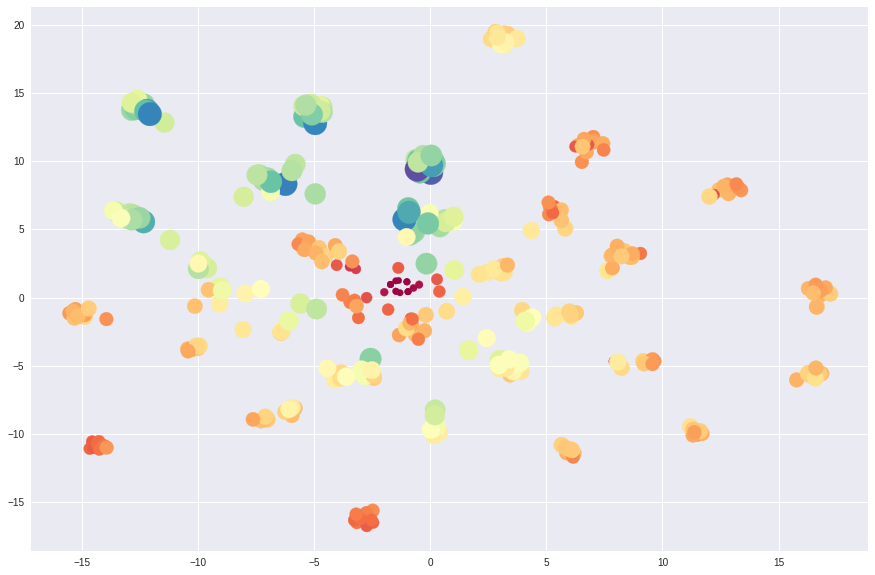

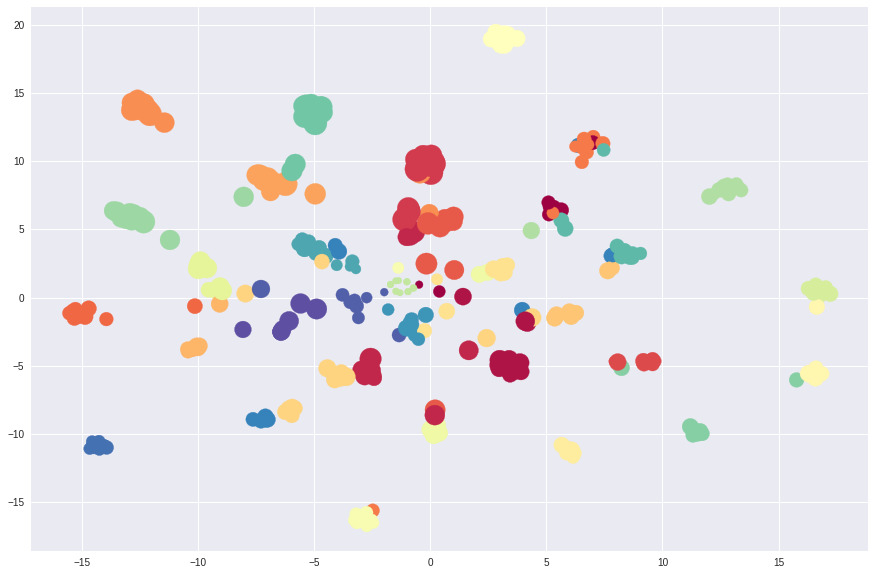

In [0]:
datavisualization(rs_df)